In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import keras

## Real-life preprocessing

In [3]:
datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples

In [4]:
# Convert reviews into short sequences of words

"""
Truncate reviews to keep first 300 characters
Use regular expression to replace unwanted tags with spaces
Replace any characters other than letters and quotes with spaces
Split by spaces
Return dense tensor, padded with token "<pad>" for equal length
"""

def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, b"<br\\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

In [5]:
for X_batch, y_batch in datasets["train"].batch(2).take(1):
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        print("Review:", review.decode("utf-8")[:200], "...")
        print("Label:", label, "= Positive" if label else "= Negative")
        print()

Review: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting  ...
Label: 0 = Negative

Review: I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However  ...
Label: 0 = Negative



In [6]:
preprocess(X_batch, y_batch)

(<tf.Tensor: shape=(2, 53), dtype=string, numpy=
 array([[b'This', b'was', b'an', b'absolutely', b'terrible', b'movie',
         b"Don't", b'be', b'lured', b'in', b'by', b'Christopher',
         b'Walken', b'or', b'Michael', b'Ironside', b'Both', b'are',
         b'great', b'actors', b'but', b'this', b'must', b'simply', b'be',
         b'their', b'worst', b'role', b'in', b'history', b'Even',
         b'their', b'great', b'acting', b'could', b'not', b'redeem',
         b'this', b"movie's", b'ridiculous', b'storyline', b'This',
         b'movie', b'is', b'an', b'early', b'nineties', b'US',
         b'propaganda', b'pi', b'<pad>', b'<pad>', b'<pad>'],
        [b'I', b'have', b'been', b'known', b'to', b'fall', b'asleep',
         b'during', b'films', b'but', b'this', b'is', b'usually', b'due',
         b'to', b'a', b'combination', b'of', b'things', b'including',
         b'really', b'tired', b'being', b'warm', b'and', b'comfortable',
         b'on', b'the', b'sette', b'and', b'having', b'j

In [7]:
from collections import Counter 

# Dict subclass for counting hashable objects
vocabulary = Counter()

for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

Let's reduce our vocabulary to the 10 000 most frequently used words:

In [8]:
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]
]

In [9]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)

# Create key/value pairs for word IDs
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)

# Add 1000 buckets for out-of-vocab words to word IDs to finalize the dictionnary
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [10]:
# Try it out
table.lookup(tf.constant([b"This is a great day".split()]))

<tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[ 22,   7,   2,  68, 279]])>

In [11]:
# The unknown word gets over 10 000 as expected
table.lookup(tf.constant([b"This is a greaaaaaat day".split()]))

<tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[   22,     7,     2, 10930,   279]])>

Let's create a function that uses our table to encode words:

In [12]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

In [13]:
train_set = datasets["train"].batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [14]:
tensorboard_cb = keras.callbacks.TensorBoard()
%load_ext tensorboard

Here is the architecture of our model:

# 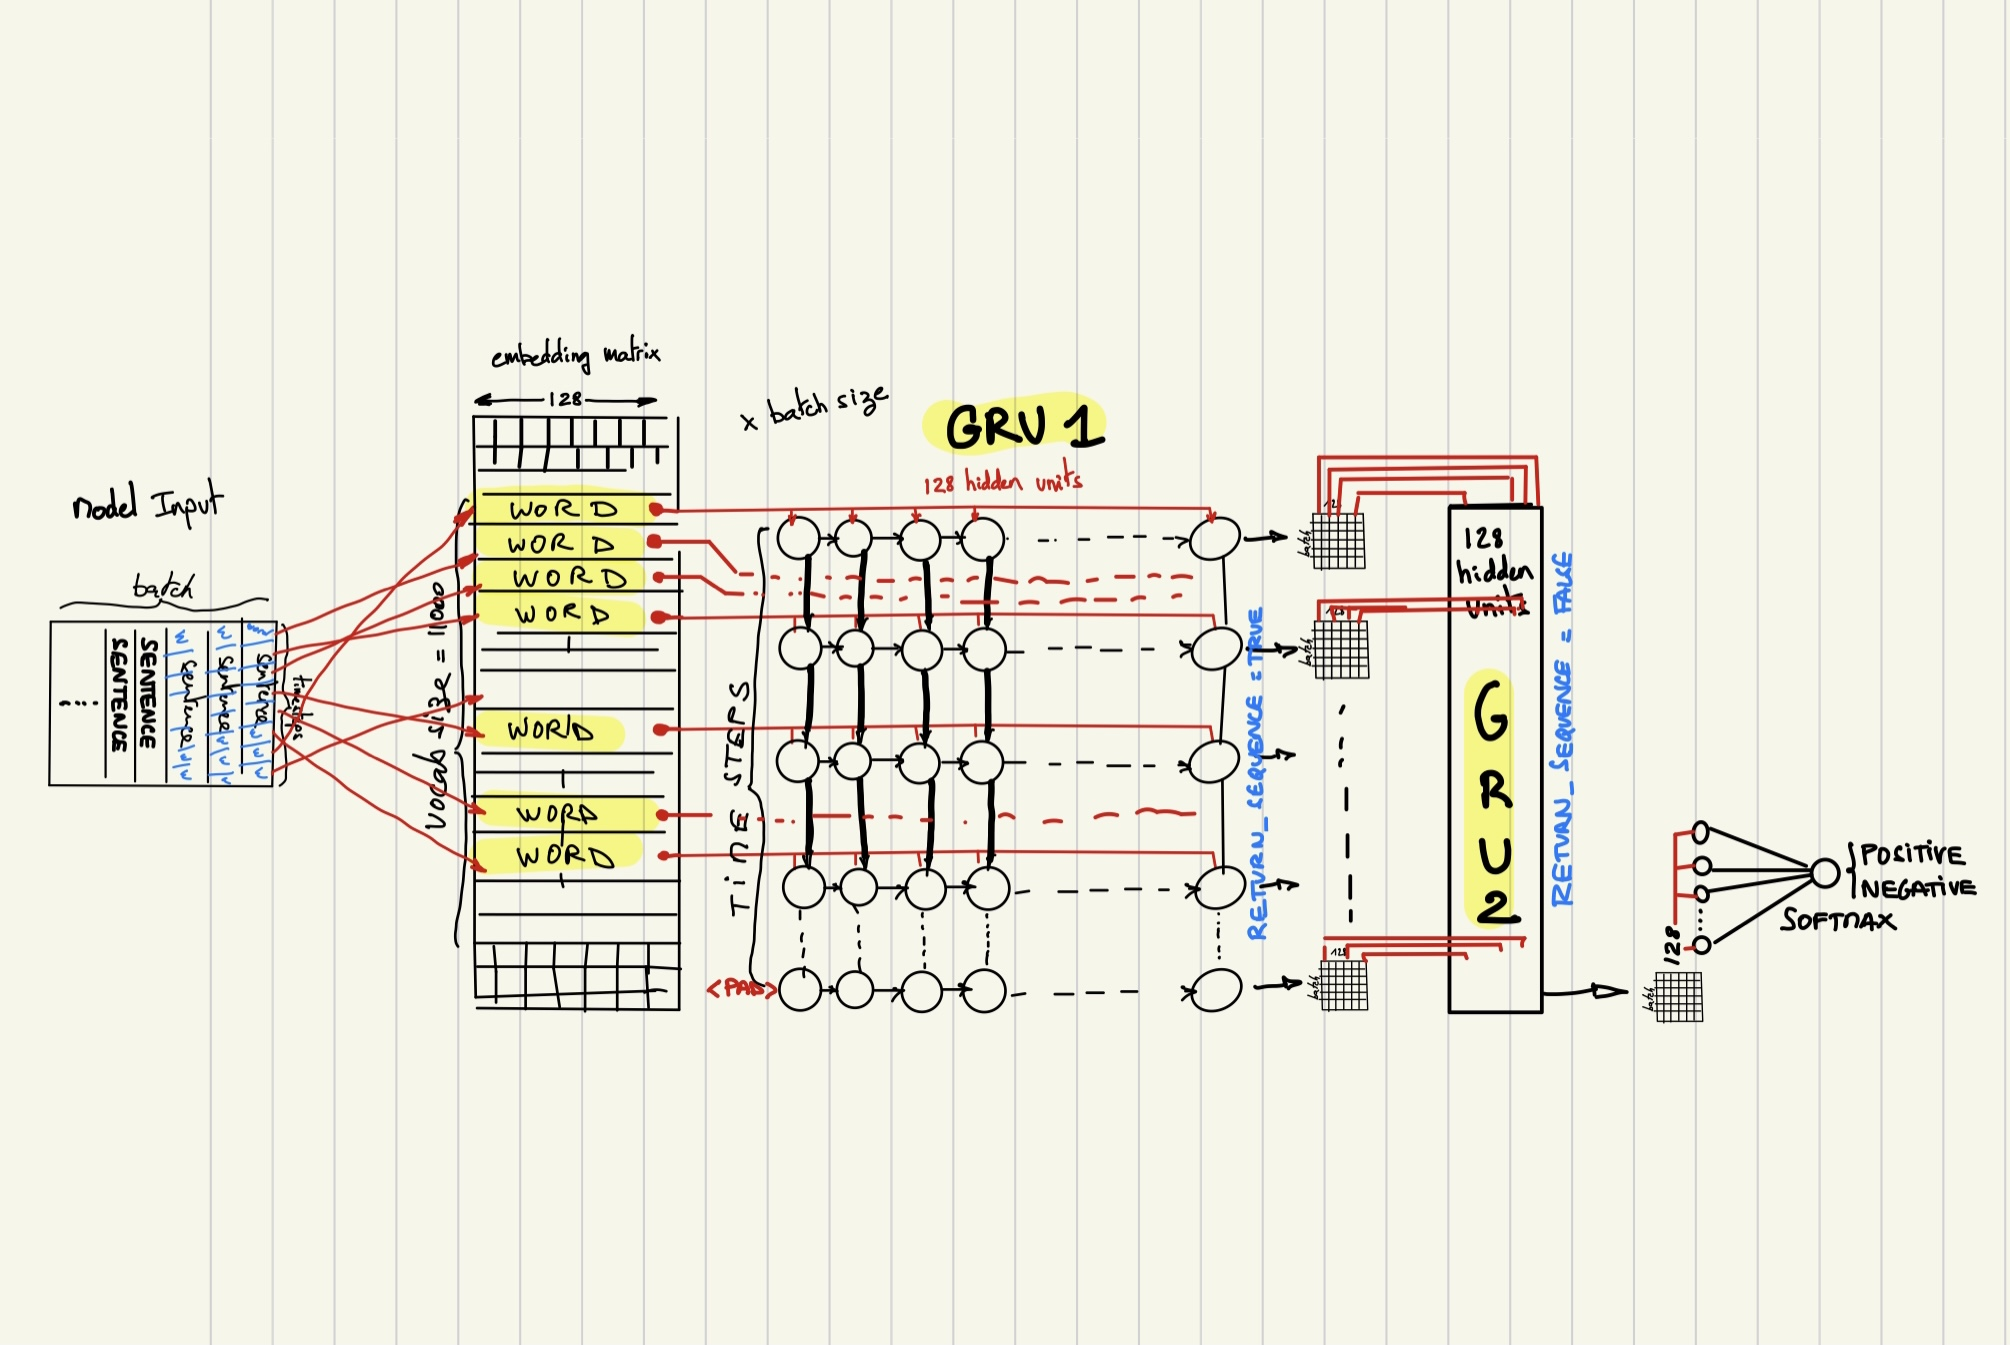

In [15]:
# Embedding matrix input size = [batch_size, time_steps]
# Embedding matrix output size = [batch_size, time_steps, embedding_dimension]

embed_size = 128

# mask_zero=True to ignore <pad> tokens.
# input_shape=[None] because sequences of any size, and feeding directly to the hidden units

model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size+num_oov_buckets, embed_size, mask_zero=True, input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, epochs=5, callbacks=[tensorboard_cb])

Epoch 1/5
782/782 [==============================] - 95s 113ms/step - loss: 0.6112 - accuracy: 0.6376
Epoch 2/5
782/782 [==============================] - 86s 110ms/step - loss: 0.3829 - accuracy: 0.8351
Epoch 3/5
782/782 [==============================] - 80s 102ms/step - loss: 0.2181 - accuracy: 0.9200
Epoch 4/5
782/782 [==============================] - 79s 101ms/step - loss: 0.1333 - accuracy: 0.9540
Epoch 5/5
782/782 [==============================] - 82s 105ms/step - loss: 0.1119 - accuracy: 0.9589


<AxesSubplot:>

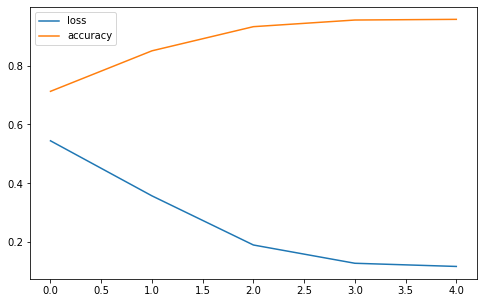

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8,5))

Let's predict a few reviews. They must be passed as tensors to the lookup() function of the embedding table:

In [41]:
model.predict(table.lookup(tf.constant([b"This movie is gorgeous".split()]))
)

array([[0.91396916]], dtype=float32)

In [47]:
model.predict(table.lookup(tf.constant([b"What a horrible movie".split()]))
)

array([[0.01556638]], dtype=float32)

In [48]:
model.predict(table.lookup(tf.constant([b"That film was okay.".split()]))
)

array([[0.641306]], dtype=float32)